<a href="https://colab.research.google.com/github/deva-sou/LaTeXRapports/blob/main/BloodCellTypesClassifcationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> # Blood Cell Types Classification Using **CNN**



# Import librairies

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

> **BEFORE RUNNING**: Make sure you selected a "GPU" runtime type



# Import dataset

> First of all upload your kaggle API key from https://www.kaggle.com/ as kaggle.json



In [ ]:
! pip install kaggle --quiet

In [4]:
! mkdir ~/.kaggle
#  kaggle.json from your kaagle API
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paultimothymooney/blood-cells
! unzip blood-cells.zip

## Adding pathfiles



In [2]:
data_dir = "dataset2-master/dataset2-master/images/TRAIN/"
test_data_dir = "dataset2-master/dataset2-master/images/TEST/"

# Data exploitation

## Mean and standard deviation calcul

In [6]:
def get_mean_and_std(train_data_path):
        # transformation method 
    training_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
    ])
    dataset = torchvision.datasets.ImageFolder(root=train_data_path, transform=training_transforms)
    loader = torch.utils.data.DataLoader(dataset= dataset, batch_size=128, shuffle=False)
    # std and mean calculation
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = get_mean_and_std(data_dir)
print("mean: ", mean)
print("std: ", std)

mean:  tensor([0.6788, 0.6414, 0.6606])
std:  tensor([0.2626, 0.2618, 0.2594])


## Image transformation and normalization

In [7]:
dataset = ImageFolder(data_dir,
                      transform = transforms.Compose([
                                                    transforms.Resize((224,224)),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.RandomRotation(10),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((mean.tolist()), (std.tolist()))
                                                    ])
                      )

test_dataset = ImageFolder(test_data_dir,
                           transform = transforms.Compose([
                                                    transforms.Resize((224,224)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((mean.tolist()), (std.tolist()))
                                                    ])
                           )

In [8]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


In [9]:
print(f"Number of images in training data : {len(dataset)}")
print(f"Number of images in test data : {len(test_dataset)}")
print("Following classes are there : \n",dataset.classes)
classes = dataset.classes

Number of images in training data : 9957
Number of images in test data : 2487
Following classes are there : 
 ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([0, 3, 3, 3, 0, 1, 3, 3, 3, 2, 1, 3, 2, 3, 3, 0, 3, 3, 3, 1, 2, 2, 3, 2,
        0, 3, 3, 3, 1, 0, 2, 1, 0, 2, 1, 3, 2, 0, 1, 1])
classes: 
 EOSINOPHIL ; NEUTROPHIL ; NEUTROPHIL ; NEUTROPHIL ; EOSINOPHIL ; LYMPHOCYTE ; NEUTROPHIL ; NEUTROPHIL ; NEUTROPHIL ; MONOCYTE ; LYMPHOCYTE ; NEUTROPHIL ; MONOCYTE ; NEUTROPHIL ; NEUTROPHIL ; EOSINOPHIL ; NEUTROPHIL ; NEUTROPHIL ; NEUTROPHIL ; LYMPHOCYTE ; MONOCYTE ; MONOCYTE ; NEUTROPHIL ; MONOCYTE ; EOSINOPHIL ; NEUTROPHIL ; NEUTROPHIL ; NEUTROPHIL ; LYMPHOCYTE ; EOSINOPHIL ; MONOCYTE ; LYMPHOCYTE ; EOSINOPHIL ; MONOCYTE ; LYMPHOCYTE ; NEUTROPHIL ; MONOCYTE ; EOSINOPHIL ; LYMPHOCYTE ; LYMPHOCYTE


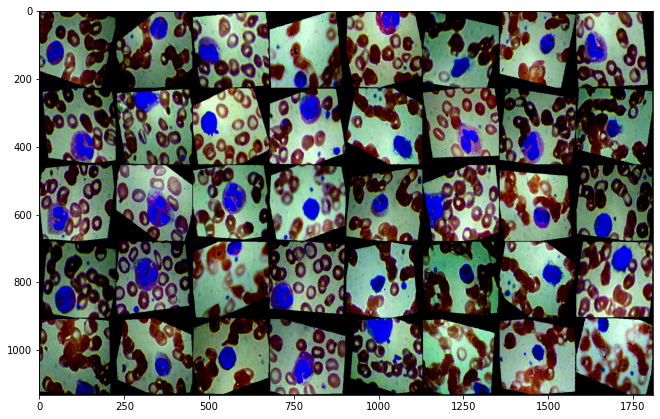

In [10]:
def show_transformed_images(dataset, nb_images):
    loader = DataLoader(dataset, batch_size=nb_images, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print("labels:", labels)
    print("classes: \n", ' ; '.join(f'{classes[labels[j]]:5s}' for j in range(nb_images)))
show_transformed_images(dataset, 40)

## Split dataset

In [11]:
val_size = 2487
train_size = len(dataset) - val_size 
train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 7470
Length of Validation Data : 2487


## Load dataset in DataLoader

In [12]:
batch_size = 128
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# CNN Pipeline

## Define pipeline

In [13]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## CNN Layers as a model

In [14]:
class WhiteBloodCellsClassifier(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(16,8, kernel_size = 3, stride = 1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(8, 4, kernel_size = 3, stride = 1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=0.2),

            nn.Flatten(),
            nn.Linear(28 * 28 * 4, 32),
            nn.ReLU(),

            nn.Linear(32, 16 ),
            nn.ReLU(),

            nn.Linear(16, 8),
            nn.ReLU(),

            nn.Linear(8, 4),
            nn.Softmax(dim=1)
        )
    
    def forward(self, xb):
        return self.network(xb)

model = WhiteBloodCellsClassifier()


## Use a GPU

In [15]:
device = torch.device('cuda:0')
print(torch.cuda.get_device_name(0))

Tesla T4


In [16]:
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

## Set up model's fit and evaluation

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

## Load model to GPU

In [28]:
model = to_device(WhiteBloodCellsClassifier(),device)

## Evaluate model

In [29]:
evaluate(model,val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.24833932518959045, 'val_loss': 1.3867459297180176}

## Set model parameters

### 10 epochs

In [88]:
#set the no. of epochs, optimizer funtion and learning rate
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.005

In [89]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.3534, val_loss: 1.2424, val_acc: 0.4974
Epoch [1], train_loss: 1.2781, val_loss: 1.1642, val_acc: 0.5773
Epoch [2], train_loss: 1.2506, val_loss: 1.1392, val_acc: 0.5996
Epoch [3], train_loss: 1.2123, val_loss: 1.1237, val_acc: 0.6109
Epoch [4], train_loss: 1.1848, val_loss: 1.0714, val_acc: 0.6641
Epoch [5], train_loss: 1.1769, val_loss: 1.0648, val_acc: 0.6655
Epoch [6], train_loss: 1.1574, val_loss: 1.0440, val_acc: 0.6940
Epoch [7], train_loss: 1.1489, val_loss: 1.0896, val_acc: 0.6447
Epoch [8], train_loss: 1.1347, val_loss: 1.0152, val_acc: 0.7271
Epoch [9], train_loss: 1.1099, val_loss: 0.9857, val_acc: 0.7584


Results: 5m17s for 10 epochs

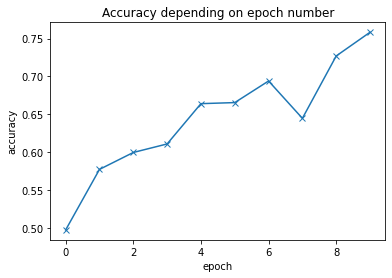

In [90]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy depending on epoch number');

plot_accuracies(history)

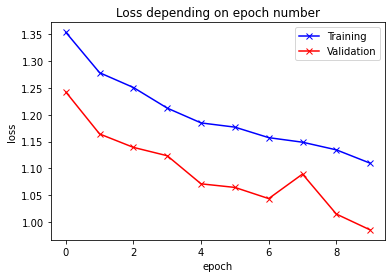

In [91]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss depending on epoch number');

plot_losses(history)

In [92]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.6346396803855896, 'val_loss': 1.0932756662368774}

In [93]:
#save the model
torch.save(model.state_dict(), 'WhiteBloodCellsClassifier.pth')

### 50 epochs

In [20]:
#set the no. of epochs, optimizer funtion and learning rate
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.005

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

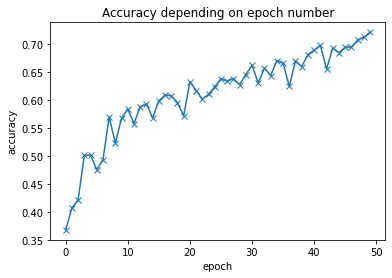

In [24]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy depending on epoch number');

plot_accuracies(history)

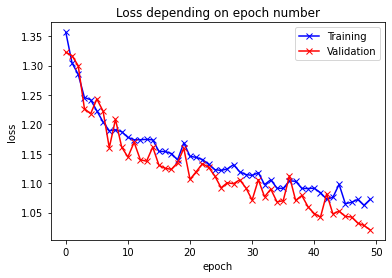

In [25]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss depending on epoch number');

plot_losses(history)

In [27]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.4902706742286682, 'val_loss': 1.240609049797058}